Note: The model used here is the modified version used in: http://docs.pymc.io/notebooks/probabilistic_matrix_factorization.html

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
import numpy as np
import os
import shutil
import pymc3 as pm
import seaborn as sns
DATA_DIR = '.'

data = pd.read_csv(os.path.join(DATA_DIR, 'jester-dataset-v1-dense-first-1000.csv'))
data.head()

sns.set_context("poster", font_scale=1.2)



WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: Unable to get the number of gpus available: CUDA driver version is insufficient for CUDA runtime version)


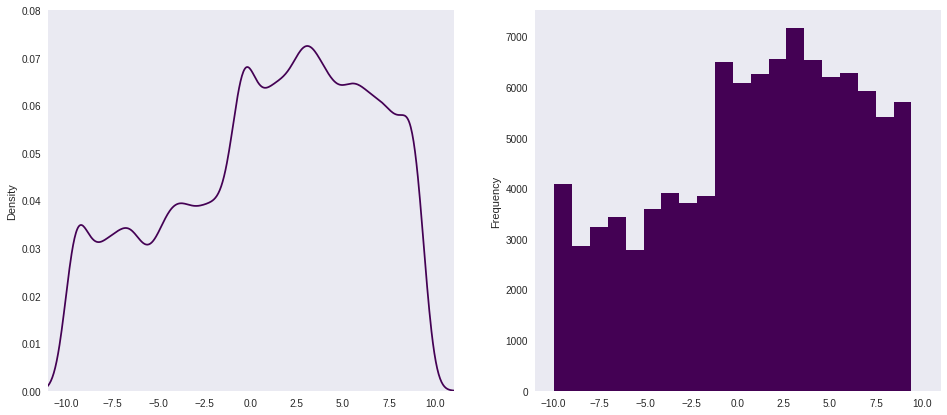

In [3]:
# Extract the ratings from the DataFrame
all_ratings = np.ndarray.flatten(data.values)
ratings = pd.Series(all_ratings)

# Plot histogram and density.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
ratings.plot(kind='density', ax=ax1, grid=False, cmap='viridis')
ax1.set_ylim(0, 0.08)
ax1.set_xlim(-11, 11)

# Plot histogram
ratings.plot(kind='hist', ax=ax2, bins=20, grid=False, cmap='viridis')
ax2.set_xlim(-11, 11)
plt.show()

In [19]:
ratings.describe()

count    100000.000000
mean          0.996219
std           5.265215
min          -9.950000
25%          -2.860000
50%           1.650000
75%           5.290000
max           9.420000
dtype: float64

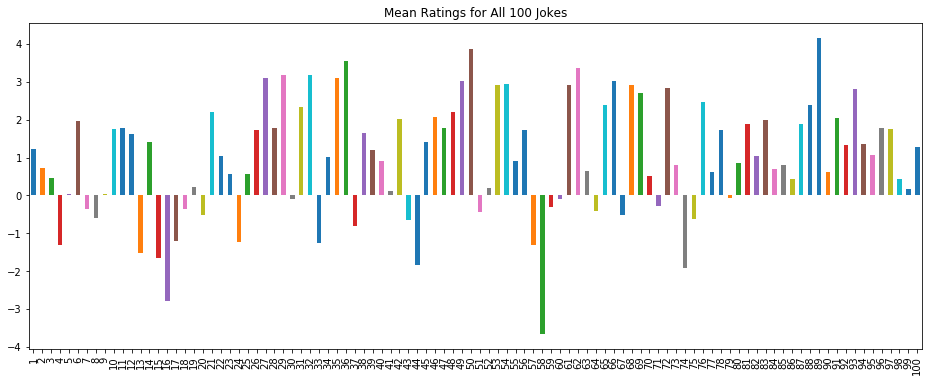

In [20]:
joke_means = data.mean(axis=0)
joke_means.plot(kind='bar', grid=False, figsize=(16, 6),
                title="Mean Ratings for All 100 Jokes")

In [21]:
import json
# Worst and best joke?
worst_joke_id = joke_means.argmin()
best_joke_id = joke_means.argmax()

# Let's see for ourselves. Load the jokes.
with open(os.path.join(DATA_DIR, 'jokes.json')) as buff:
    joke_dict = json.load(buff)

print('The worst joke:\n---------------\n%s\n' % joke_dict[worst_joke_id])
print('The best joke:\n--------------\n%s' % joke_dict[best_joke_id])

The worst joke:
---------------
How many teddybears does it take to change a lightbulb?

It takes only one teddybear, but it takes a whole lot of lightbulbs.


The best joke:
--------------
*A radio conversation of a US naval 
ship with Canadian authorities ... *

Americans: Please divert your course 15 degrees to the North to avoid a
collision.

Canadians: Recommend you divert YOUR course 15 degrees to the South to 
avoid a collision.

Americans: This is the Captain of a US Navy ship.  I say again, divert 
YOUR course.

Canadians: No.  I say again, you divert YOUR course.

Americans: This is the aircraft carrier USS LINCOLN, the second largest ship in the United States' Atlantic Fleet. We are accompanied by three destroyers, three cruisers and numerous support vessels. I demand that you change your course 15 degrees north, that's ONE FIVE DEGREES NORTH, or counter-measures will be undertaken to ensure the safety of this ship.

Canadians: *This is a lighthouse.  Your call*.



/home/uras/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/uras/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  after removing the cwd from sys.path.


[]

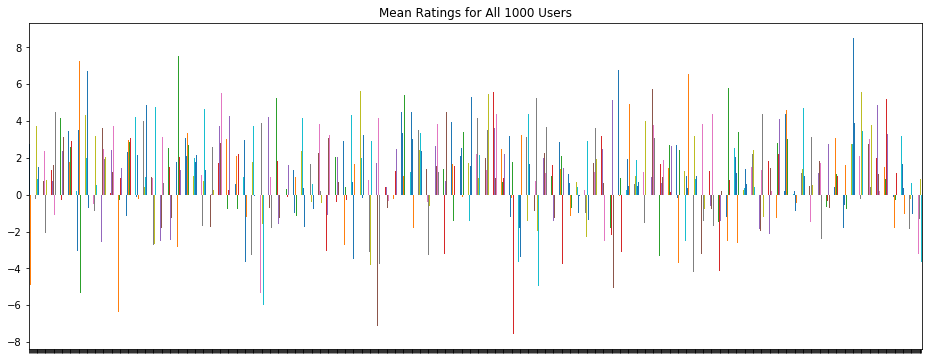

In [22]:
user_means = data.mean(axis=1)
_, ax = plt.subplots(figsize=(16, 6))
user_means.plot(kind='bar', grid=False, ax=ax,
                title="Mean Ratings for All 1000 Users")
ax.set_xticklabels('')  # 1000 labels is nonsensical

In [4]:
from collections import OrderedDict

# Create a base class with scaffolding for our 3 baselines.

def split_title(title):
    """Change "BaselineMethod" to "Baseline Method"."""
    words = []
    tmp = [title[0]]
    for c in title[1:]:
        if c.isupper():
            words.append(''.join(tmp))
            tmp = [c]
        else:
            tmp.append(c)
    words.append(''.join(tmp))
    return ' '.join(words)


class Baseline(object):
    """Calculate baseline predictions."""

    def __init__(self, train_data):
        """Simple heuristic-based transductive learning to fill in missing
        values in data matrix."""
        self.predict(train_data.copy())

    def predict(self, train_data):
        raise NotImplementedError(
            'baseline prediction not implemented for base class')

    def rmse(self, test_data):
        """Calculate root mean squared error for predictions on test data."""
        return rmse(test_data, self.predicted)

    def __str__(self):
        return split_title(self.__class__.__name__)



# Implement the 3 baselines.

class UniformRandomBaseline(Baseline):
    """Fill missing values with uniform random values."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        pmin, pmax = masked_train.min(), masked_train.max()
        N = nan_mask.sum()
        train_data[nan_mask] = np.random.uniform(pmin, pmax, N)
        self.predicted = train_data


class GlobalMeanBaseline(Baseline):
    """Fill in missing values using the global mean."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        train_data[nan_mask] = train_data[~nan_mask].mean()
        self.predicted = train_data


class MeanOfMeansBaseline(Baseline):
    """Fill in missing values using mean of user/item/global means."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        global_mean = masked_train.mean()
        user_means = masked_train.mean(axis=1)
        item_means = masked_train.mean(axis=0)
        self.predicted = train_data.copy()
        n, m = train_data.shape
        for i in range(n):
            for j in range(m):
                if np.ma.isMA(item_means[j]):
                    self.predicted[i,j] = np.mean(
                        (global_mean, user_means[i]))
                else:
                    self.predicted[i,j] = np.mean(
                        (global_mean, user_means[i], item_means[j]))


baseline_methods = OrderedDict()
baseline_methods['ur'] = UniformRandomBaseline
baseline_methods['gm'] = GlobalMeanBaseline
baseline_methods['mom'] = MeanOfMeansBaseline

The ratings <span class="math">\(R\)</span> are modeled as
draws from a Gaussian distribution. The mean for <span class="math">\(R_{ij}\)</span> is
<span class="math">\(U_i V_j^T\)</span>. The precision <span class="math">\(\alpha\)</span> is a fixed parameter
that reflects the uncertainty of the estimations; the normal
distribution is commonly reparameterized in terms of precision, which is
the inverse of the variance. Complexity is controlled by placing
zero-mean spherical Gaussian priors on <span class="math">\(U\)</span> and <span class="math">\(V\)</span>. In other
words, each row of <span class="math">\(U\)</span> is drawn from a multivariate Gaussian with
mean <span class="math">\(\mu = 0\)</span> and precision which is some multiple of the
identity matrix <span class="math">\(I\)</span>. Those multiples are <span class="math">\(\alpha_U\)</span> for
<span class="math">\(U\)</span> and <span class="math">\(\alpha_V\)</span> for <span class="math">\(V\)</span>. So our model is defined
by:</p>


\begin{equation}
\newcommand\given[1][]{\:#1\vert\:}
P(R \given U, V, \alpha^2) =
    \prod_{i=1}^N \prod_{j=1}^M
        \left[ \mathcal{N}(R_{ij} \given U_i V_j^T, \alpha^{-1}) \right]^{I_{ij}}
\end{equation}</div><div class="math">
\begin{equation}
P(U \given \alpha_U^2) =
    \prod_{i=1}^N \mathcal{N}(U_i \given 0, \alpha_U^{-1} \boldsymbol{I})
\end{equation}</div><div class="math">
\begin{equation}
P(V \given \alpha_U^2) =
    \prod_{j=1}^M \mathcal{N}(V_j \given 0, \alpha_V^{-1} \boldsymbol{I})
\end{equation}

In [5]:
import time
import logging
import theano
import scipy as sp


# Enable on-the-fly graph computations, but ignore
# absence of intermediate test values.
theano.config.compute_test_value = 'ignore'

# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)


class PMF(object):
    """Probabilistic Matrix Factorization model using pymc3."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(-10, 10)):
        """Build the Probabilistic Matrix Factorization model using pymc3.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info('building the PMF model')
        with pm.Model() as pmf:
            U = pm.MvNormal(
                'U', mu=0, tau=self.alpha_u * np.eye(dim),
                shape=(n, dim), testval=np.random.randn(n, dim) * std)
            V = pm.MvNormal(
                'V', mu=0, tau=self.alpha_v * np.eye(dim),
                shape=(m, dim), testval=np.random.randn(m, dim) * std)
            R = pm.Normal(
                'R', mu=theano.tensor.dot(U, V.T), tau=self.alpha * np.ones((n, m)),
                observed=self.data)

        logging.info('done building the PMF model')
        self.model = pmf

    def __str__(self):
        return self.name

<p>We’ll also need functions for calculating the MAP and performing
sampling on our PMF model. When the observation noise variance
<span class="math">\(\alpha\)</span> and the prior variances <span class="math">\(\alpha_U\)</span> and
<span class="math">\(\alpha_V\)</span> are all kept fixed, maximizing the log posterior is
equivalent to minimizing the sum-of-squared-errors objective function
with quadratic regularization terms.</p>

\begin{equation}
E = \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^M I_{ij} (R_{ij} - U_i V_j^T)^2 + \frac{\lambda_U}{2} \sum_{i=1}^N \|U\|_{Fro}^2 + \frac{\lambda_V}{2} \sum_{j=1}^M \|V\|_{Fro}^2
\end{equation}

where

\begin{equation}
\lambda_U = \alpha_U / \alpha,
\end{equation}
\begin{equation}
\lambda_V = \alpha_V / \alpha
\end{equation}

and 

\begin{equation}
\|\cdot\|_{Fro}^2\
\end{equation}

denotes the Frobenius norm. Minimizing this objective function gives
a local minimum, which is essentially a maximum a posteriori (MAP)
estimate.

In [6]:
try:
    import ujson as json
except ImportError:
    import json


# First define functions to save our MAP estimate after it is found.
# We adapt these from `pymc3`'s `backends` module, where the original
# code is used to save the traces from MCMC samples.
def save_np_vars(vars, savedir):
    """Save a dictionary of numpy variables to `savedir`. We assume
    the directory does not exist; an OSError will be raised if it does.
    """
    logging.info('writing numpy vars to directory: %s' % savedir)
    if not os.path.isdir(savedir):
        os.mkdir(savedir)
    shapes = {}
    for varname in vars:
        data = vars[varname]
        var_file = os.path.join(savedir, varname + '.txt')
        np.savetxt(var_file, data.reshape(-1, data.size))
        shapes[varname] = data.shape

        ## Store shape information for reloading.
        shape_file = os.path.join(savedir, 'shapes.json')
        with open(shape_file, 'w') as sfh:
            json.dump(shapes, sfh)


def load_np_vars(savedir):
    """Load numpy variables saved with `save_np_vars`."""
    shape_file = os.path.join(savedir, 'shapes.json')
    with open(shape_file, 'r') as sfh:
        shapes = json.load(sfh)

    vars = {}
    for varname, shape in shapes.items():
        var_file = os.path.join(savedir, varname + '.txt')
        vars[varname] = np.loadtxt(var_file).reshape(shape)

    return vars


# Now define the MAP estimation infrastructure.
def _map_dir(self):
    basename = 'pmf-map-d%d' % self.dim
    return os.path.join(DATA_DIR, basename)

def _find_map(self):
    """Find mode of posterior using Powell optimization."""
    tstart = time.time()
    with self.model:
        logging.info('finding PMF MAP using Powell optimization...')
        self._map = pm.find_MAP()

    elapsed = int(time.time() - tstart)
    logging.info('found PMF MAP in %d seconds' % elapsed)

    # This is going to take a good deal of time to find, so let's save it.
    save_np_vars(self._map, self.map_dir)

def _load_map(self):
    self._map = load_np_vars(self.map_dir)

def _map(self):
    try:
        return self._map
    except:
        if os.path.isdir(self.map_dir):
            self.load_map()
        else:
            self.find_map()
        return self._map


# Update our class with the new MAP infrastructure.
PMF.find_map = _find_map
PMF.load_map = _load_map
PMF.map_dir = property(_map_dir)
PMF.map = property(_map)

In [7]:
# Draw MCMC samples.
def _trace_dir(self):
    basename = 'pmf-mcmc-d%d' % self.dim
    return os.path.join(DATA_DIR, basename)

def _draw_samples(self, nsamples=1000, njobs=2):
    # First make sure the trace_dir does not already exist.
    if os.path.isdir(self.trace_dir):
        shutil.rmtree(self.trace_dir)

    with self.model:
        logging.info('drawing %d samples using %d jobs' % (nsamples, njobs))
        backend = pm.backends.Text(self.trace_dir)
        logging.info('backing up trace to directory: %s' % self.trace_dir)
        self.trace = pm.sample(draws=nsamples, init='advi',
                               n_init=150000, njobs=njobs, trace=backend)

def _load_trace(self):
    with self.model:
        self.trace = pm.backends.text.load(self.trace_dir)


# Update our class with the sampling infrastructure.
PMF.trace_dir = property(_trace_dir)
PMF.draw_samples = _draw_samples
PMF.load_trace = _load_trace

Finally, we’ll need a function to make predictions
using our inferred values for <span class="math">\(U\)</span> and <span class="math">\(V\)</span>. For user
<span class="math">\(i\)</span> and joke <span class="math">\(j\)</span>, a prediction is generated by drawing from
<span class="math">\(\mathcal{N}(U_i V_j^T, \alpha)\)</span>. To generate predictions from the
sampler, we generate an <span class="math">\(R\)</span> matrix for each <span class="math">\(U\)</span> and
<span class="math">\(V\)</span> sampled, then we combine these by averaging over the <span class="math">\(K\)</span>
samples.</p>
<div class="math">
\begin{equation}
P(R_{ij}^* \given R, \alpha, \alpha_U, \alpha_V) \approx
    \frac{1}{K} \sum_{k=1}^K \mathcal{N}(U_i V_j^T, \alpha)
\end{equation}</div><p>
    
We’ll want to inspect the individual <span class="math">\(R\)</span> matrices before averaging
them for diagnostic purposes. So we’ll write code for the averaging
piece during evaluation. The function below simply draws an <span class="math">\(R\)</span>
matrix given a <span class="math">\(U\)</span> and <span class="math">\(V\)</span> and the fixed <span class="math">\(\alpha\)</span>
stored in the PMF object.</p>

In [8]:
def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    n, m = R.shape
    sample_R = np.array([
        [np.random.normal(R[i,j], self.std) for j in range(m)]
        for i in range(n)
    ])

    # bound ratings
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R


PMF.predict = _predict

<p>In order to understand how effective our models are, we’ll need to be
able to evaluate them. We’ll be evaluating in terms of root mean squared
error (RMSE), which looks like this:</p>
<div class="math">
\begin{equation}
RMSE = \sqrt{ \frac{ \sum_{i=1}^N \sum_{j=1}^M I_{ij} (R_{ij} - R_{ij}^*)^2 }
                   { \sum_{i=1}^N \sum_{j=1}^M I_{ij} } }
\end{equation}</div><p>In this case, the RMSE can be thought of as the standard deviation of
our predictions from the actual user preferences.</p>

In [9]:
# Define our evaluation function.
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)   # indicator for missing values
    N = I.sum()                # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N                 # mean squared error
    return np.sqrt(mse)                        # RMSE


In [11]:
import hashlib


# Define a function for splitting train/test data.
def split_train_test(data, percent_test=10):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """
    n, m = data.shape             # # users, # jokes
    N = n * m                     # # cells in matrix
    test_size = int(N / percent_test)  # use 10% of data as test set
    train_size = N - test_size    # and remainder for training

    # Prepare train/test ndarrays.
    train = data.copy().values
    test = np.ones(data.shape) * np.nan

    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(train))       # ignore nan values in data
    idx_pairs = list(zip(tosample[0], tosample[1]))   # tuples of row/col index pairs
    indices = np.arange(len(idx_pairs))         # indices of index pairs
    sample = np.random.choice(indices, replace=False, size=test_size)

    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan          # remove from train set

    # Verify everything worked properly
    assert(np.isnan(train).sum() == test_size)
    assert(np.isnan(test).sum() == train_size)

    # Finally, hash the indices and save the train/test sets.
    index_string = ''.join(map(str, np.sort(sample)))
    name = hashlib.sha1(index_string.encode('utf-8')).hexdigest()
    savedir = os.path.join(DATA_DIR, name)
    save_np_vars({'train': train, 'test': test}, savedir)

    # Return train set, test set, and unique hash of indices.
    return train, test, name


def load_train_test(name):
    """Load the train/test sets."""
    savedir = os.path.join(DATA_DIR, name)
    vars = load_np_vars(savedir)
    return vars['train'], vars['test']

# train, test, name = split_train_test(data)

In [12]:
train, test = load_train_test('d0b5c3f5036e02e5fc6050d60d7a9fd8bd11b536')

In [13]:
# Let's see the results:
baselines = {}
for name in baseline_methods:
    Method = baseline_methods[name]
    method = Method(train)
    baselines[name] = method.rmse(test)
    print('%s RMSE:\t%.5f' % (method, baselines[name]))

Uniform Random Baseline RMSE:	7.73524
Global Mean Baseline RMSE:	5.23008
Mean Of Means Baseline RMSE:	4.76210


In [14]:
# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 2

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each joke. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Jester dataset, this means we have D(1100), so for 5
# dimensions, we are sampling 5500 latent variables.
DIM = 5


pmf = PMF(train, DIM, ALPHA, std=0.05)

INFO:root:building the PMF model
INFO:root:done building the PMF model


In [15]:
# Find MAP for PMF.
pmf.find_map()

INFO:root:finding PMF MAP using Powell optimization...
logp = -1.5538e+06, ||grad|| = 8.8422: 100%|██████████| 91/91 [00:00<00:00, 432.51it/s]      
INFO:root:found PMF MAP in 1 seconds
INFO:root:writing numpy vars to directory: ./pmf-map-d5


In [16]:
def eval_map(pmf_model, train, test):
    U = pmf_model.map['U']
    V = pmf_model.map['V']

    # Make predictions and calculate RMSE on train & test sets.
    predictions = pmf_model.predict(U, V)
    train_rmse = rmse(train, predictions)
    test_rmse = rmse(test, predictions)
    overfit = test_rmse - train_rmse

    # Print report.
    print('PMF MAP training RMSE: %.5f' % train_rmse)
    print('PMF MAP testing RMSE:  %.5f' % test_rmse)
    print('Train/test difference: %.5f' % overfit)

    return test_rmse


# Add eval function to PMF class.
PMF.eval_map = eval_map

In [17]:
# Evaluate PMF MAP estimates.
pmf_map_rmse = pmf.eval_map(train, test)
pmf_improvement = baselines['mom'] - pmf_map_rmse
print('PMF MAP Improvement:   %.5f' % pmf_improvement)

PMF MAP training RMSE: 4.00016
PMF MAP testing RMSE:  4.15489
Train/test difference: 0.15473
PMF MAP Improvement:   0.60721


In [18]:
# Draw MCMC samples.
pmf.draw_samples(500)

# uncomment to load previous trace rather than drawing new samples.
# pmf.load_trace()

INFO:root:drawing 500 samples using 2 jobs
INFO:root:backing up trace to directory: ./pmf-mcmc-d5
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = 1.5632e+06:  51%|█████     | 76501/150000 [03:29<03:21, 365.08it/s]
Interrupted at 76,510 [51%]: Average Loss = 1.6528e+06
INFO:pymc3.variational.inference:Interrupted at 76,510 [51%]: Average Loss = 1.6528e+06
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [V, U]
INFO:pymc3:NUTS: [V, U]
100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


<p>The next step is to check how many samples we should discard as burn-in.
Normally, we’d do this using a traceplot to get some idea of where the
sampled variables start to converge. In this case, we have
high-dimensional samples, so we need to find a way to approximate them.
One way was proposed by <a class="reference external" href="https://www.cs.toronto.edu/~amnih/papers/bpmf.pdf">Salakhutdinov and Mnih,
p.886</a>. We can
calculate the Frobenius norms of <span class="math">\(U\)</span> and <span class="math">\(V\)</span> at each step
and monitor those for convergence. This essentially gives us some idea
when the average magnitude of the latent variables is stabilizing. The
equations for the Frobenius norms of <span class="math">\(U\)</span> and <span class="math">\(V\)</span> are shown
below. We will use <code class="docutils literal"><span class="pre">numpy</span></code>’s <code class="docutils literal"><span class="pre">linalg</span></code> package to calculate these.</p>
\begin{equation}
\|U\|_{Fro}^2 = \sqrt{\sum_{i=1}^N \sum_{d=1}^D |U_{id}|^2}, \hspace{40pt} \|V\|_{Fro}^2 = \sqrt{\sum_{j=1}^M \sum_{d=1}^D |V_{jd}|^2}
\end{equation}

In [50]:
def _norms(pmf_model, monitor=('U', 'V'), ord='fro'):
    """Return norms of latent variables at each step in the
    sample trace. These can be used to monitor convergence
    of the sampler.
    """
    monitor = ('U', 'V')
    norms = {var: [] for var in monitor}
    for sample in pmf_model.trace:
        for var in monitor:
            norms[var].append(np.linalg.norm(sample[var], ord))
    return norms


def _traceplot(pmf_model):
    """Plot Frobenius norms of U and V as a function of sample #."""
    trace_norms = pmf_model.norms()
    u_series = pd.Series(trace_norms['U'])
    v_series = pd.Series(trace_norms['V'])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    u_series.plot(kind='line', ax=ax1, grid=False,
                  title="$\|U\|_{Fro}^2$ at Each Sample")
    v_series.plot(kind='line', ax=ax2, grid=False,
                  title="$\|V\|_{Fro}^2$ at Each Sample")
    ax1.set_xlabel("Sample Number")
    ax2.set_xlabel("Sample Number")
    fig.savefig('traceplot1.png')


PMF.norms = _norms
PMF.traceplot = _traceplot

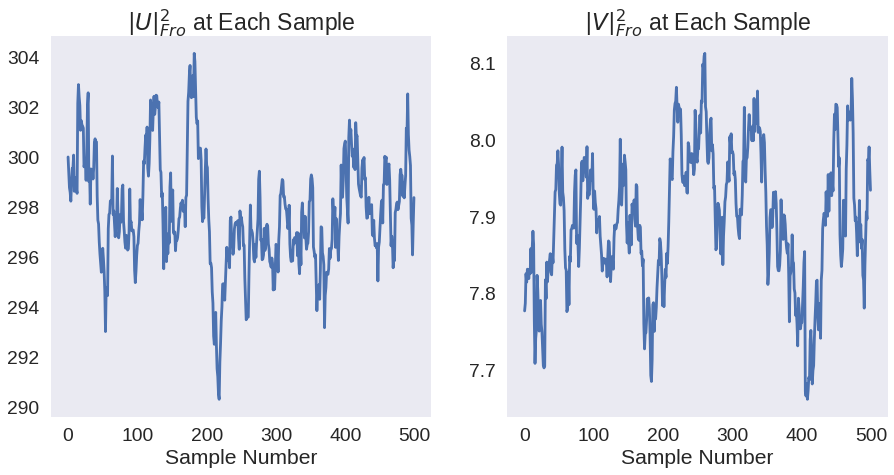

In [51]:
pmf.traceplot()

In [25]:
def _running_rmse(pmf_model, test_data, train_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence.
    """
    burn_in = burn_in if len(pmf_model.trace) >= burn_in else 0
    results = {'per-step-train': [], 'running-train': [],
               'per-step-test': [], 'running-test': []}
    R = np.zeros(test_data.shape)
    for cnt, sample in enumerate(pmf_model.trace[burn_in:]):
        sample_R = pmf_model.predict(sample['U'], sample['V'])
        R += sample_R
        running_R = R / (cnt + 1)
        results['per-step-train'].append(rmse(train_data, sample_R))
        results['running-train'].append(rmse(train_data, running_R))
        results['per-step-test'].append(rmse(test_data, sample_R))
        results['running-test'].append(rmse(test_data, running_R))

    results = pd.DataFrame(results)      

    # Return the final predictions, and the RMSE calculations
    return running_R, results


PMF.running_rmse = _running_rmse

In [26]:
predicted, results = pmf.running_rmse(test, train, burn_in=300)

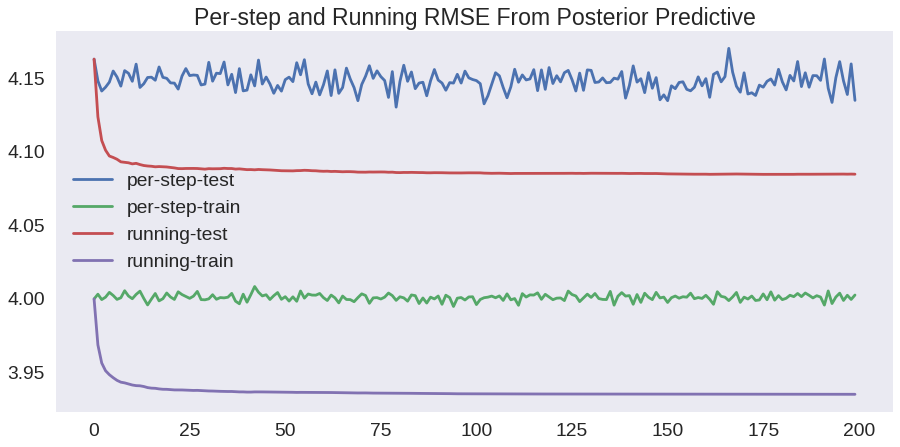

In [48]:
plot = results.plot(
            kind='line', grid=False, figsize=(15, 7),
            title='Per-step and Running RMSE From Posterior Predictive')
fig = plot.get_figure()
fig.savefig(os.path.join(DATA_DIR, 'running_rmse1.png'))

In [28]:
# And our final RMSE?
final_test_rmse = results['running-test'].values[-1]
final_train_rmse = results['running-train'].values[-1]
print('Posterior predictive train RMSE: %.5f' % final_train_rmse)
print('Posterior predictive test RMSE:  %.5f' % final_test_rmse)
print('Train/test difference:           %.5f' % (final_test_rmse - final_train_rmse))
print('Improvement from MAP:            %.5f' % (pmf_map_rmse - final_test_rmse))
print('Improvement from Mean of Means:  %.5f' % (baselines['mom'] - final_test_rmse))

Posterior predictive train RMSE: 3.93479
Posterior predictive test RMSE:  4.08479
Train/test difference:           0.15000
Improvement from MAP:            0.07009
Improvement from Mean of Means:  0.67731


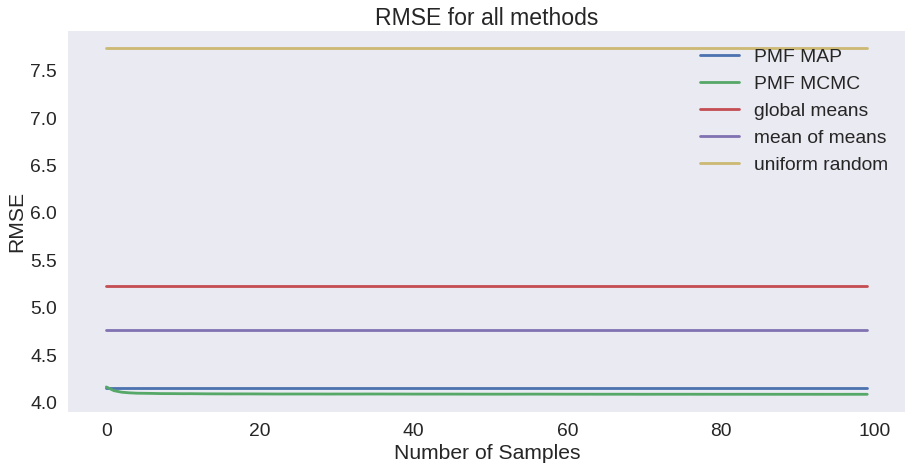

In [47]:
size = 100  # RMSE doesn't really change after 100th sample anyway.
all_results = pd.DataFrame({
    'uniform random': np.repeat(baselines['ur'], size),
    'global means': np.repeat(baselines['gm'], size),
    'mean of means': np.repeat(baselines['mom'], size),
    'PMF MAP': np.repeat(pmf_map_rmse, size),
    'PMF MCMC': results['running-test'][:size],
})
fig, ax = plt.subplots(figsize=(15, 7))
all_results.plot(kind='line', grid=False, ax=ax,
                 title='RMSE for all methods')
ax.set_xlabel("Number of Samples")
ax.set_ylabel("RMSE")
plt.savefig(os.path.join(DATA_DIR, 'RMSEall1.png'))